# FACTS Whitepaper Validation Notebook
The purpose of this notebook is to provide users the ability to run all FACTS coupling.ssp experiments and generate the necessary plots and tables consistent with the FACTS v1.1.1 whitepaper (see "docs"). As an early version of this notebook it is subject to change. 

## Using the Notebook
The notebook is designed to be plug and play. Currently the only user input required is the following:
1. (root_dir) needs to be specified as the root directory for this FACTS install, uses /opt/facts by default
2. If necessary or relevant, adjust the (facts_version) variable
3. Right now it will perform all coupling.ssp experiments

In [ ]:
import os
import dask
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PlotLib import *

In [ ]:
# root_dir needs to be specified as the root directory for this FACTS install, uses /opt/facts by default
root_dir = "/home/alex/rutgers/facts/branches/whitepaper/facts"
facts_version = "v1.1.3"
run_ssps = False

os.chdir(root_dir)
exp_dir = os.path.join(root_dir,'experiments')
resource_dir = os.path.join(root_dir,'resources')
out_dir = os.path.join(root_dir,'notebooks/Plotting/data/')
plot_dir = os.path.join(root_dir,'notebooks/Plotting/plots/')

In [ ]:
import runFACTS
scenarios = ['coupling.ssp119', 'coupling.ssp126', 'coupling.ssp245', 'coupling.ssp370','coupling.ssp585']

if run_ssps:
    lazy_scenario = [dask.delayed(runFACTS.run_experiment(exp_dir=os.path.join(exp_dir, f'{ssp}'), 
                                                      resourcedir=resource_dir, 
                                                      outdir=out_dir)) for ssp in scenarios] 
    run_scenarios = dask.compute(*lazy_scenario)

In [ ]:
# Create the utility object
util = PlotLib(root_dir=root_dir, 
               version_flag=facts_version)

mods = [
        'emulandice_ais',
        'emulandice_gris',
        'emulandice_glaciers',
        'ipccar5_glaciers',
        'ipccar5_ais',
        'ipccar5_gris',
        'larmip_ais',
        'fittedismip_gris',
        'tlm_sterodynamics',
        'bamber19_ais',
        'bamber19_gris',
        'deconto21_ais',
]

for i in range(len(mods)):
    util.plot_module(mod_idx=i, module=mods[i], exp_name='coupling.ssp')

# Component Projections for 2100 by SSP

In [ ]:
print(util.ssp_quantiles.to_string())

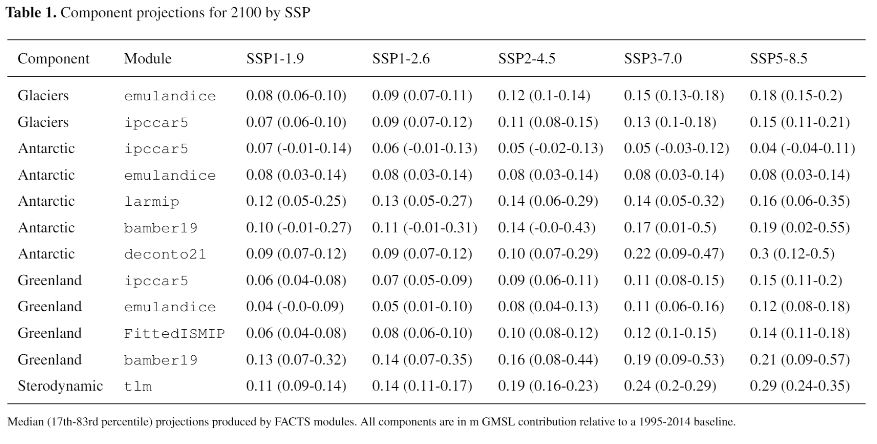

# Component Projections for 2100 by GSAT Bin

In [ ]:
print(util.temp_qauntiles.to_string())

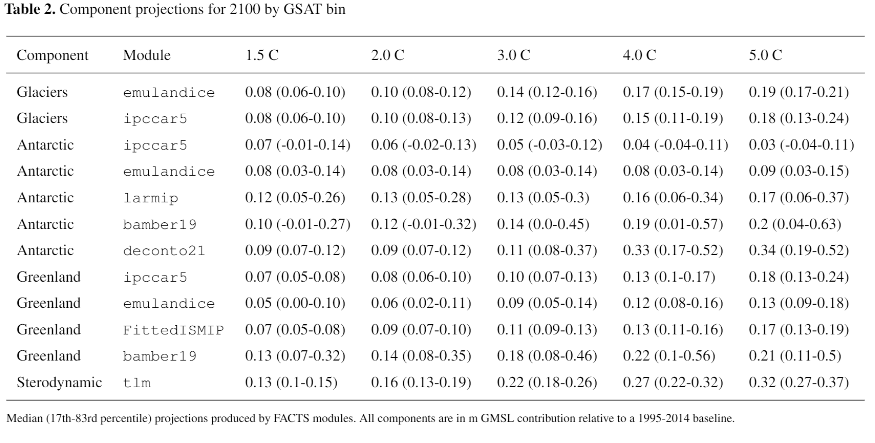

# Total GMSL Projections for 2100 by GSAT Bin compared to AR6 Warming Level Projections

In [ ]:
util = PlotLib(root_dir=root_dir, 
               version_flag=facts_version)

mods = [
        'wf1e_global',
        'wf1f_global',
        'wf2e_global',
        'wf2f_global',
        'wf3e_global',
        'wf3f_global',
        'wf4_global',
]

for i in range(len(mods)):
    util.plot_module(mod_idx=i, module=mods[i], exp_name='coupling.ssp')

In [ ]:
print(util.temp_qauntiles.to_string())

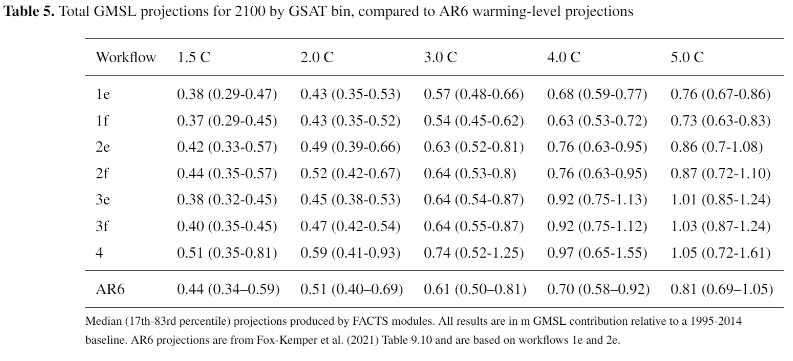